# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist

import micmac as micmac

In [2]:
PRNGKey = random.PRNGKey(0)


In [3]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [4]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


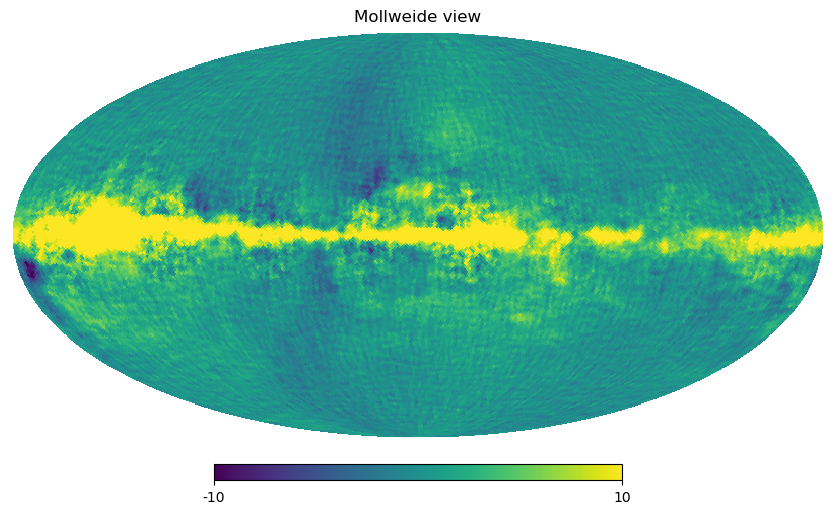

In [5]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npix

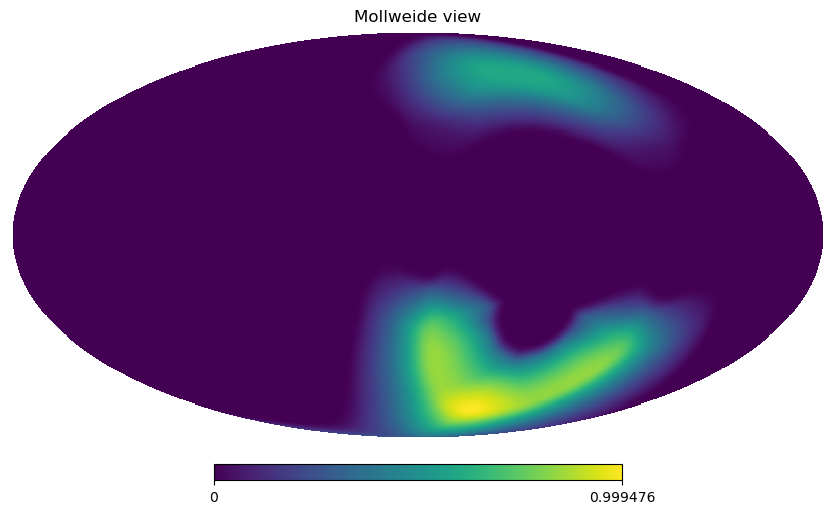

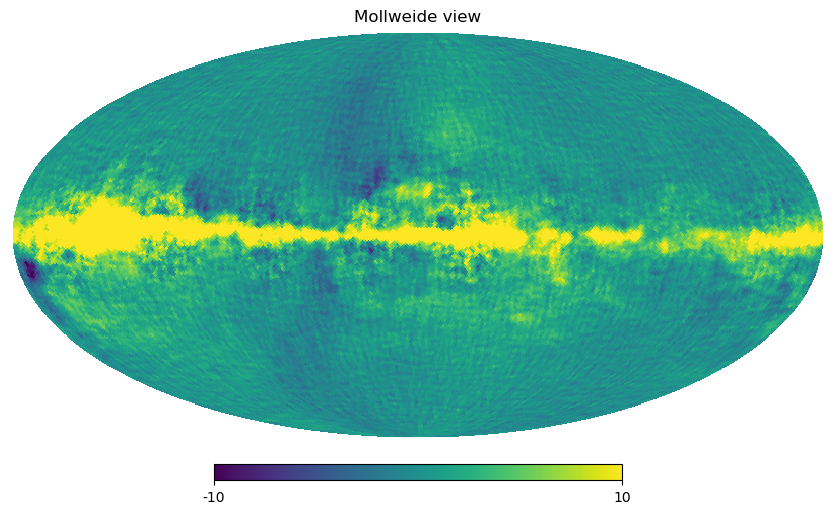

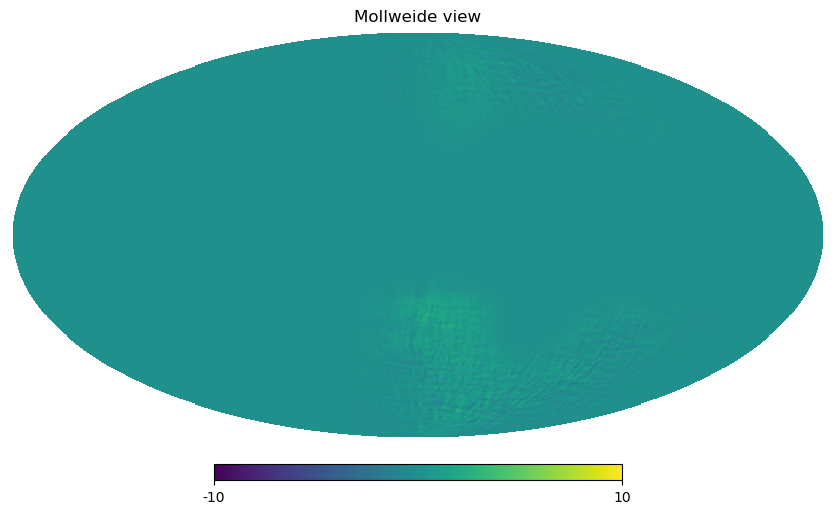

In [6]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npixhp.mollview(freq_maps[0,0]) # Freq, nstokes, npix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, npix

In [7]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
# path_toml_file = directory_toml_file + 'corr_full_chain_v3a.toml'
# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1cd.toml'


In [8]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [9]:
reduction_noise = 1

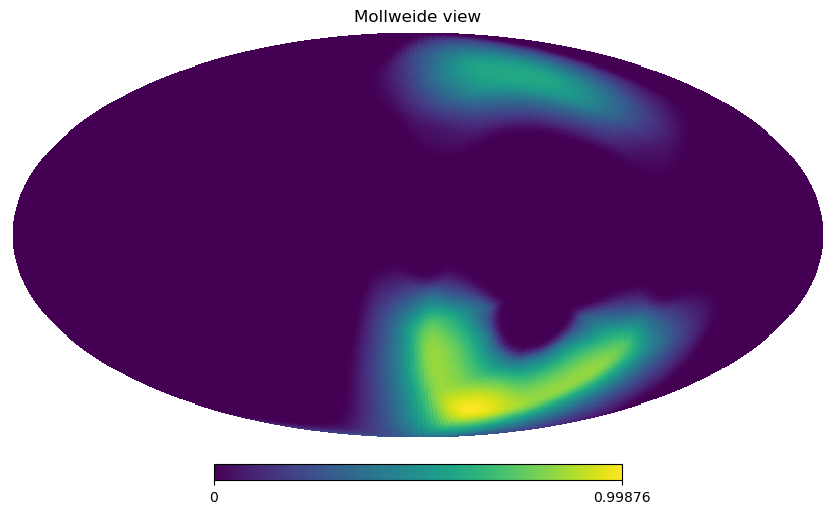

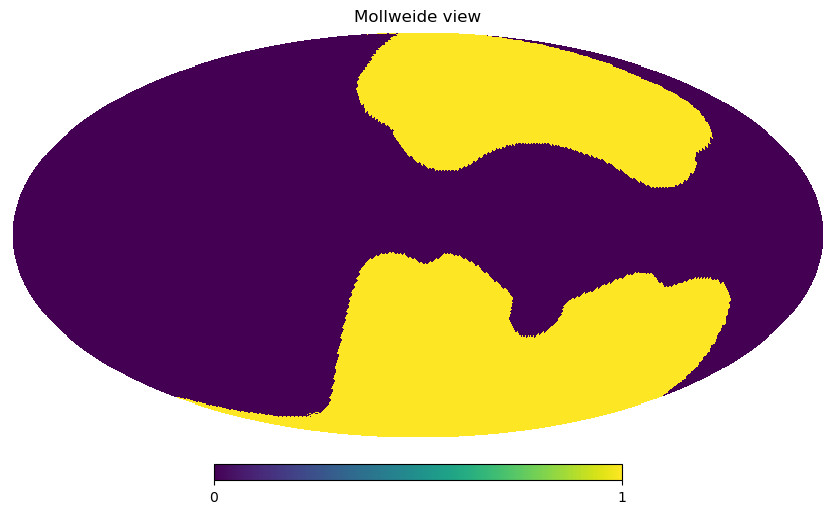

In [10]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1
hp.mollview(apod_mask)
hp.mollview(mask)

In [11]:
mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = mask

In [12]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise_0 = micmac.get_noise_covar(instrument['depth_p'], MICMAC_sampler_obj.nside) #MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise_0.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked
freq_inverse_noise = freq_inverse_noise_masked


In [13]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [14]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [15]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

# BtinvNB_fullsky = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt_fullsky = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
# BtinvN_fullsky = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)#*mask

BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

nb_pix_mask = int(np.sum(mask))

# BtinvNB = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.npix))
# BtinvNB[:,:,mask!=0] = np.repeat(BtinvNB_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_components, nb_pix_mask), order='C')

# BtinvN_sqrt = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))
# BtinvN_sqrt[:,:,mask!=0] = np.repeat(BtinvN_sqrt_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_frequencies, nb_pix_mask), order='C')

# BtinvN = np.zeros((MICMAC_sampler_obj.number_components,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))
# BtinvN[:,:,mask!=0] = np.repeat(BtinvN_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.number_components, MICMAC_sampler_obj.number_frequencies, nb_pix_mask), order='C')


In [16]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
# true_cmb_specra = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')

# input_cmb_maps = 

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [17]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [18]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [19]:
number_frequencies = MICMAC_sampler_obj.number_frequencies
number_components = MICMAC_sampler_obj.number_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
npix = 12*nside**2

In [20]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

N_c_inv_repeat = np.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,npix), order='F').ravel()

In [21]:
N_c_inv_repeat[:npix][N_c_inv_repeat[:npix]!=N_c_inv]

Array([], dtype=float64)

In [22]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = None
map_random_realization_chi = None
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps_v2c(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
# fluctuation_maps = get_fluctuating_term_maps_test(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, mask_to_use=mask, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
print("Finished fluct !")


Recalculating xi !
Recalculating chi !
CG Fluct finished in  10.814961194992065 seconds !!
CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
Finished fluct !
CPU times: user 1min 7s, sys: 7.85 s, total: 1min 15s
Wall time: 13.9 s


In [23]:
jitted_get_fluctuating_term_maps = jax.jit(MICMAC_sampler_obj.get_fluctuating_term_maps)

In [24]:
%%time
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2c(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 1min 1s, sys: 7.28 s, total: 1min 8s
Wall time: 11.4 s


In [25]:
jitted_solve_generalized_wiener_filter_term = jax.jit(MICMAC_sampler_obj.solve_generalized_wiener_filter_term)

In [26]:
s_c_sample = wiener_filter_term + fluctuation_maps

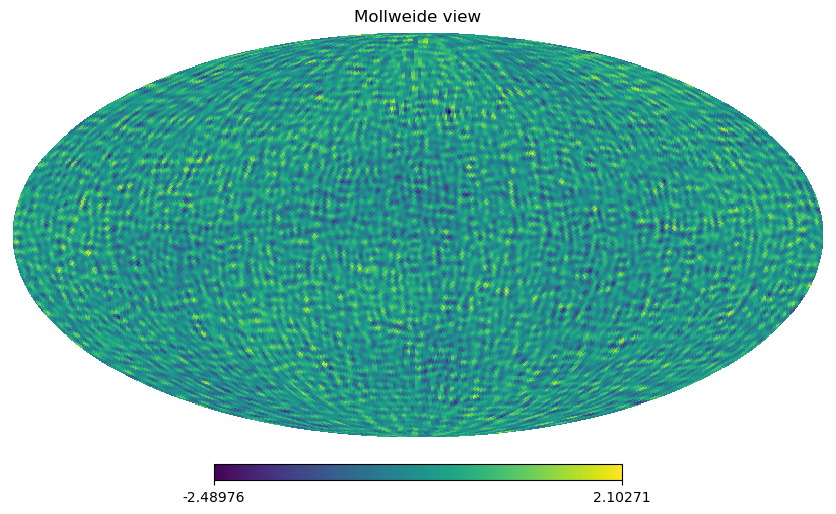

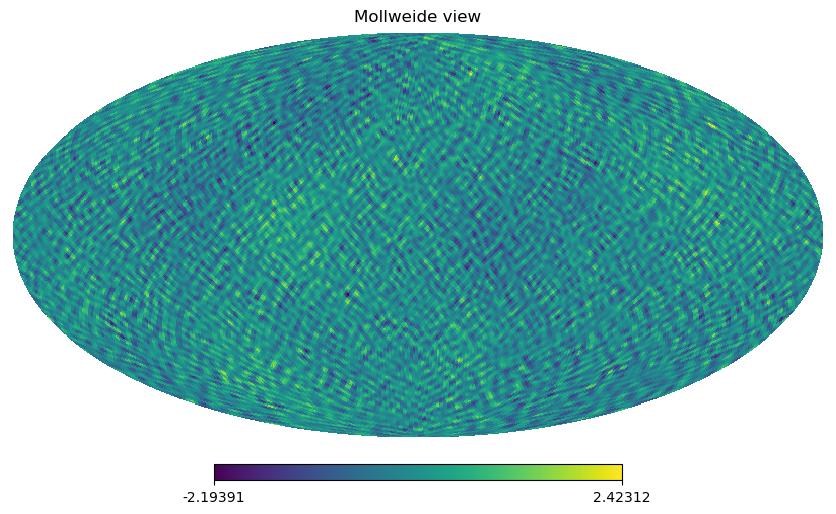

In [27]:
hp.mollview(s_c_sample[0])
hp.mollview(s_c_sample[1])

In [28]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [29]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

In [30]:
fsky = mask.sum()/mask.size
fsky = 1#mask.sum()/mask.size

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


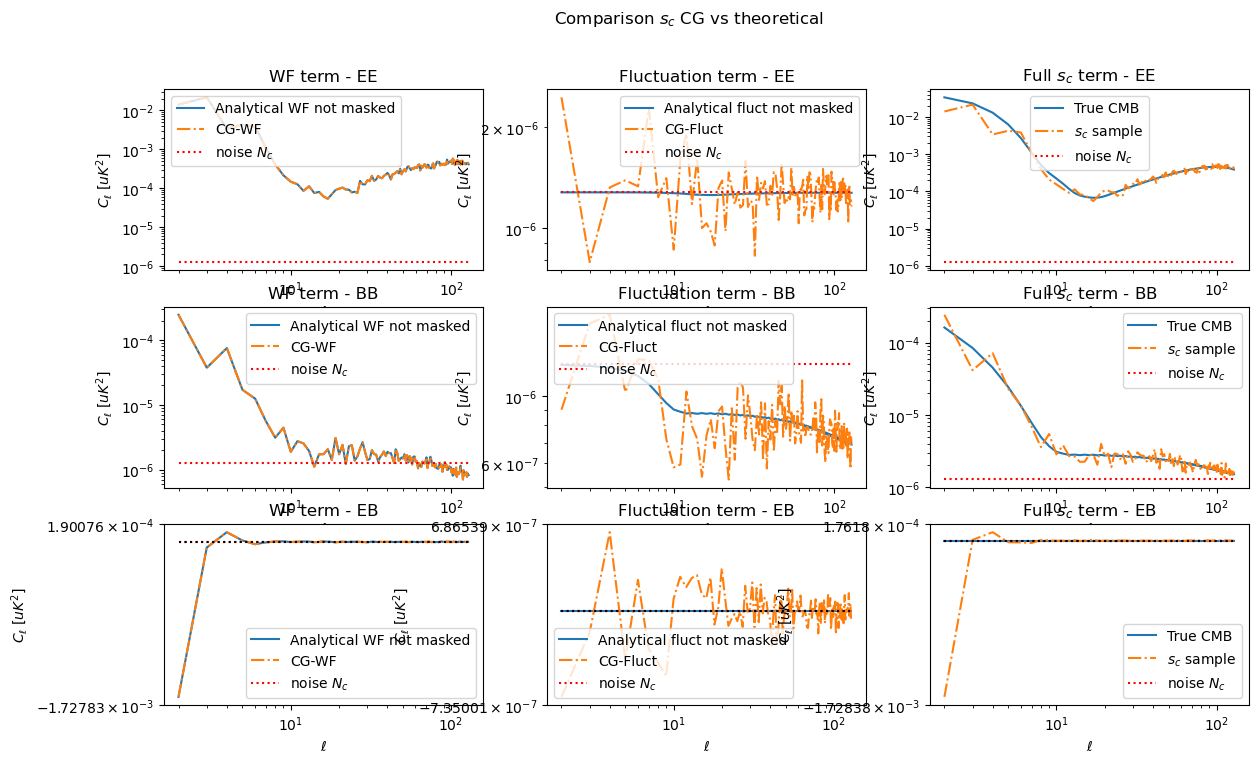

In [31]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
#                                                                         analytical_WF_harm, lmin=lmin, n_iter=n_iter)

s_cML_unmasked = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML_unmasked/BtinvNB[0,0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF not masked')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:]/fsky, '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct not masked')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:]/fsky, '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:]/fsky, '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [32]:
jnp.any(jnp.linalg.eigvalsh(red_cov_matrix_sample)<0, axis=(1))#.shape
# jnp.linalg.eigh(red_cov_matrix_sample)
jnp.prod(jnp.linalg.eigvalsh(red_cov_matrix_sample), axis=(1))#.shape

Array([5.43492023e-06, 1.94776209e-06, 5.86238264e-07, 1.53358216e-07,
       3.60727873e-08, 8.60481872e-09, 2.54412738e-09, 1.15091009e-09,
       6.85339204e-10, 4.69271128e-10, 3.27129672e-10, 2.56338372e-10,
       2.16808336e-10, 2.04584944e-10, 1.92036002e-10, 1.90595144e-10,
       1.88033381e-10, 1.97566366e-10, 2.05489961e-10, 2.23170732e-10,
       2.35013531e-10, 2.55493335e-10, 2.67512121e-10, 2.88826648e-10,
       3.00332794e-10, 3.22158930e-10, 3.32106004e-10, 3.53744833e-10,
       3.63388479e-10, 3.86237367e-10, 3.95551988e-10, 4.18791491e-10,
       4.26872427e-10, 4.50663580e-10, 4.58214435e-10, 4.82926546e-10,
       4.89391670e-10, 5.13923812e-10, 5.18929630e-10, 5.43560496e-10,
       5.47413009e-10, 5.72294057e-10, 5.75045850e-10, 6.00154370e-10,
       6.01709436e-10, 6.26912485e-10, 6.27125347e-10, 6.52211362e-10,
       6.50947034e-10, 6.75915730e-10, 6.73282455e-10, 6.98192741e-10,
       6.94238395e-10, 7.19111224e-10, 7.13867714e-10, 7.38638593e-10,
      

In [33]:
jnp.linalg.eigh(red_cov_matrix_sample)[1].shape

(127, 2, 2)

In [67]:
red_cov_matrix_sample = jnp.array(red_cov_matrix_sample)

In [61]:

def log_proba_proposal(new_sample, old_sample, step_size, grad_proba, **model_kwargs):
    """ Return log proba proposal distribution MALA
    """
    # term = jnp.copy(new_sample - old_sample - step_size*grad_proba(old_sample, **model_kwargs))
    term = jnp.copy(new_sample - old_sample - jnp.einsum('l,lik->lik',step_size,grad_proba(old_sample, **model_kwargs)))
    term = term.at[:,0,1].set(0)
    return -1/(4*step_size)*jnp.linalg.norm(term,ord=2,axis=(1,2))**2


def get_MALA_step(random_PRNGKey, old_sample, step_size, log_proba, grad_proba, **model_kwargs):
    """ Compute Metropolis-adjusted Langevin (MALA) step for a given log-probability function and its gradient.
    """

    rng_key, key_proposal, key_accept = random.split(random_PRNGKey, 3)

    fluctuation = dist.Normal(jnp.ravel(old_sample,order='F'), jnp.ones(jnp.size(old_sample))).sample(key_proposal)
    fluctuation_diag = ((fluctuation.reshape(old_sample.shape,order='F') + jnp.transpose(fluctuation.reshape(old_sample.shape,order='F'),axes=(0,2,1)))/2)

    # u_proposal = old_sample + step_size*grad_proba(old_sample, **model_kwargs) + fluctuation_diag*jnp.sqrt(2*step_size)
    u_proposal = old_sample + jnp.einsum('l,lik->lik',step_size,grad_proba(old_sample, **model_kwargs)) + jnp.einsum('lik,l->lik',fluctuation_diag,jnp.sqrt(2*step_size))

    diff_proposal = -(log_proba_proposal(u_proposal, old_sample, step_size, grad_proba, **model_kwargs) 
                        - log_proba_proposal(old_sample, u_proposal, step_size, grad_proba, **model_kwargs))

    accept_prob = -(log_proba(old_sample, **model_kwargs) - log_proba(u_proposal, **model_kwargs)) + diff_proposal
    
    # new_sample = jnp.where(jnp.log(dist.Uniform().sample(key_accept)) < accept_prob, u_proposal, jnp.ravel(old_sample,order='F'))
    # new_sample = jnp.where(jnp.log(dist.Uniform().sample(key_accept)) < accept_prob, u_proposal, old_sample)
    acceptance = jnp.where(jnp.log(dist.Uniform().sample(key_accept, sample_shape=(old_sample.shape[0],))) < accept_prob, 1, 0)

    eigen_prod = jnp.prod(jnp.linalg.eigvalsh(u_proposal), axis=(1))
    acceptance = jnp.where(eigen_prod<0, 0, acceptance)
    # print("Test", acceptance.shape, old_sample.shape, u_proposal.shape)
    new_sample = jnp.copy(old_sample)
    new_sample = new_sample.at[acceptance==1,...].set(u_proposal[acceptance==1,...])

    return new_sample.reshape(old_sample.shape,order='F')


In [62]:
    def get_log_proba_C(input_red_cov_matrix_sampled, red_sigma_ell):
        """ Compute log-proba of C parametrized by r_param. The associated log proba is :
                -1/2 (tr sigma_ell C(r)^-1) - 1/2 log det C(r)

            Parameters
            ----------
            :param r_param: parameter of the covariance C to be sampled
            :param red_sigma_ell: covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param theoretical_red_cov_r1_tensor: tensor mode covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param theoretical_red_cov_r0_total: scalar mode covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

            Returns
            -------
            :return: log-proba of C parametrized by r_param
        """
        red_cov_matrix_sampled = input_red_cov_matrix_sampled.reshape((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.nstokes, MICMAC_sampler_obj.nstokes), order='F')
        # Getting determinant of the covariance matrix
        all_dets = ( (2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) * jnp.log(jnp.linalg.det(red_cov_matrix_sampled)) )#.sum()
        
        return -( jnp.einsum('lij,lji->l', red_sigma_ell, jnp.linalg.pinv(red_cov_matrix_sampled)) + all_dets)/2
    
    def get_grad_log_proba_C(input_red_cov_matrix_sampled, red_sigma_ell):
        """ Compute log-proba of C parametrized by r_param. The associated log proba is :
                -1/2 (tr sigma_ell C(r)^-1) - 1/2 log det C(r)

            Parameters
            ----------
            :param r_param: parameter of the covariance C to be sampled
            :param red_sigma_ell: covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param theoretical_red_cov_r1_tensor: tensor mode covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param theoretical_red_cov_r0_total: scalar mode covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

            Returns
            -------
            :return: log-proba of C parametrized by r_param
        """
        red_cov_matrix_sampled = input_red_cov_matrix_sampled.reshape((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.nstokes, MICMAC_sampler_obj.nstokes), order='F')

        def get_deriv_cov_matrix(index_nstokes):
            init = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes)).ravel()
            init = init.at[index_nstokes].set(1)
            return init.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes))

        deriv_cov_matrix = jax.vmap(get_deriv_cov_matrix)(jnp.arange(MICMAC_sampler_obj.nstokes**2))

        def map_grad_log_proba_C(ell):
            """ Compute the gradient of the log-proba of C parametrized by r_param for a given ell
            """
            inverse_red_cov_matrix_sampled = jnp.linalg.pinv(red_cov_matrix_sampled[ell])
        
            first_term = -jnp.einsum('ij,jk,pkm,mi->p', red_sigma_ell[ell], inverse_red_cov_matrix_sampled, deriv_cov_matrix, inverse_red_cov_matrix_sampled).reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes)
            second_term = inverse_red_cov_matrix_sampled*(2*ell+1)
            # second_term = jnp.einsum('ij,pji->p', inverse_red_cov_matrix_sampled, deriv_cov_matrix)*(2*ell+1)
            # return (first_term + second_term).reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes)
            return first_term + second_term

        grad_log_proba_C = jax.vmap(map_grad_log_proba_C)(jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1))
        return -grad_log_proba_C/2



    def get_diagonal_Fisher_log_proba_C(input_red_cov_matrix_sampled, red_sigma_ell):
        """ Compute log-proba of C parametrized by r_param. The associated log proba is :
                -1/2 (tr sigma_ell C(r)^-1) - 1/2 log det C(r)

            Parameters
            ----------
            :param r_param: parameter of the covariance C to be sampled
            :param red_sigma_ell: covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param theoretical_red_cov_r1_tensor: tensor mode covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            :param theoretical_red_cov_r0_total: scalar mode covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

            Returns
            -------
            :return: log-proba of C parametrized by r_param
        """
        red_cov_matrix_sampled = input_red_cov_matrix_sampled.reshape((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.nstokes, MICMAC_sampler_obj.nstokes), order='F')

        def get_deriv_cov_matrix(index_nstokes):
            init = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes)).ravel()
            init = init.at[index_nstokes].set(1)
            return init.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes))

        deriv_cov_matrix = jax.vmap(get_deriv_cov_matrix)(jnp.arange(MICMAC_sampler_obj.nstokes**2))

        def map_Fisher_log_proba_C(ell):
            """ Compute the gradient of the log-proba of C parametrized by r_param for a given ell
            """
            inverse_red_cov_matrix_sampled = jnp.linalg.pinv(red_cov_matrix_sampled[ell])
        
            first_term_1 = -jnp.einsum('ij,jk,akm,mn,bno,oi->ab', red_sigma_ell[ell], inverse_red_cov_matrix_sampled, deriv_cov_matrix, inverse_red_cov_matrix_sampled, deriv_cov_matrix, inverse_red_cov_matrix_sampled)
            first_term_2 = -jnp.transpose(first_term_1)

            first_term = jnp.diag(first_term_1 + first_term_2)
            second_term = -jnp.diag(jnp.einsum('ik,akm,mn,bni->ab', inverse_red_cov_matrix_sampled, deriv_cov_matrix, inverse_red_cov_matrix_sampled, deriv_cov_matrix)*(2*ell+1))
            return (first_term + second_term).reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes)

        Fisher_log_proba_C = jax.vmap(map_Fisher_log_proba_C)(jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1))
        return -Fisher_log_proba_C/2


In [80]:
number_steps_sampler = 15000
# number_steps_sampler = 5000
# number_steps_sampler = 2500
# number_steps_sampler = 1000
# number_steps_sampler = 500
# number_steps_sampler = 100
# initial_step_size_r = 10**(-3)
# initial_step_size_r = 10**(-6)
# initial_guess_r = 1e-2
# initial_guess_r = 1e-4
# initial_guess_r = MICMAC_sampler_obj.r_true*0.99999

# num_sample_AM = 1000
# epsilon_cov = 10**(-20)
# scale_param = 2.4**2

In [81]:
c_ells_Wishart = jnp.zeros((3,lmax+1))
# c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
c_ells_Wishart = c_ells_Wishart.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

# c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)

In [82]:
c_ells_Wishart_modified = jnp.copy(c_ells_Wishart)
# for i in range(MICMAC_sampler_obj.nstokes):
for i in range(c_ells_Wishart.shape[0]):
        c_ells_Wishart_modified = c_ells_Wishart_modified.at[i].set(c_ells_Wishart_modified[i] * (2*jnp.arange(MICMAC_sampler_obj.lmax+1) + 1))
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified)[MICMAC_sampler_obj.lmin:]

red_true_c_ells_modified = jnp.einsum('lij,l->lij', theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor, 2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1) + 1)
red_test_Fisher_modified = jnp.einsum('ij,l,l->lij', 10**(-4)*jnp.eye(nstokes), 1/(jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)*(jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1)), 2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1) + 1)


In [83]:
# step_size_to_test = jnp.linalg.pinv(get_diagonal_Fisher_log_proba_C(red_cov_matrix_sample, red_true_c_ells_modified))
step_size_to_test = jnp.linalg.pinv(get_diagonal_Fisher_log_proba_C(red_cov_matrix_sample, red_test_Fisher_modified))

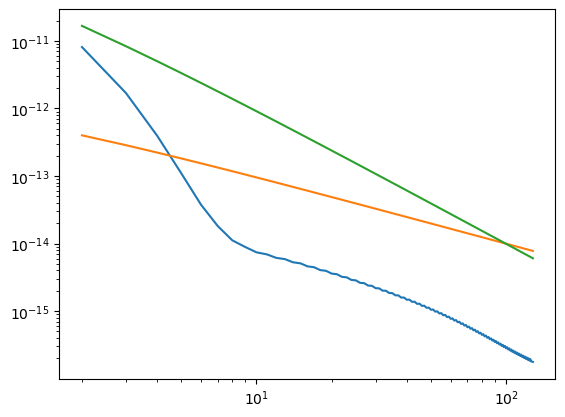

In [84]:
plt.plot(ell_array, step_size_to_test[:,1,1]/100)
plt.plot(ell_array, 1e-12*2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1))
plt.plot(ell_array, 1e-10/(ell_array*(ell_array+1)))
plt.loglog()
plt.show()

In [99]:
%%time

jitted_get_MALA_step = jax.jit(get_MALA_step)
jitted_get_log_proba_C = jax.jit(get_log_proba_C)
jitted_get_grad_log_proba_C = jax.jit(get_grad_log_proba_C)

red_all_C_sample = jnp.zeros((number_steps_sampler+1, lmax+1-lmin, nstokes,nstokes))
red_all_C_sample = red_all_C_sample.at[0].set(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)
# red_all_C_sample = red_all_C_sample.at[0].set(theoretical_red_cov_r0_total + 1e-3 * theoretical_red_cov_r1_tensor)

# all_r_sample_slow = jnp.zeros(number_steps_sampler+1)
# all_r_sample_slow = all_r_sample_slow.at[0].set(initial_guess_r)

ell_array = jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)

# tau_MALA = 1e-12
# tau_MALA = 1e-14
# tau_MALA = 1e-12*jnp.sqrt(2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1))
# tau_MALA = 1e-15*jnp.sqrt(2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1))
tau_MALA = 1e-12*2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1)
# tau_MALA = 1e-14*2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1)
# tau_MALA = 1e-15*2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1)
# tau_MALA = step_size_to_test[:,1,1]*2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1)
# tau_MALA = step_size_to_test[:,1,1]*1e-2
# tau_MALA = step_size_to_test[:,0,0]#*2/(2*jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1)+1)

for i in range(0,number_steps_sampler+1):
    PRNGKeyn, subPRNGKey = random.split(PRNGKey)
    if i%1000 == 0:
        print('Step {}'.format(i))

    # red_all_C_sample = red_all_C_sample.at[i+1].set(get_MALA_step(random_PRNGKey=PRNGKey, old_sample=red_all_C_sample[i], 
    #                                     step_size=tau_MALA, log_proba=get_log_proba_C, grad_proba=get_grad_log_proba_C,
    #                                     red_sigma_ell=red_c_ells_Wishart_modified).reshape((lmax+1-lmin, nstokes, nstokes), order='F'))
    red_all_C_sample = red_all_C_sample.at[i+1].set(get_MALA_step(random_PRNGKey=PRNGKey, old_sample=red_all_C_sample[i], 
                                        step_size=tau_MALA, log_proba=jitted_get_log_proba_C, grad_proba=jitted_get_grad_log_proba_C,
                                        red_sigma_ell=red_c_ells_Wishart_modified).reshape((lmax+1-lmin, nstokes, nstokes), order='F'))



Step 0
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Step 6000
Step 7000
Step 8000
Step 9000
Step 10000
Step 11000
Step 12000
Step 13000
Step 14000
Step 15000
CPU times: user 2min 42s, sys: 826 ms, total: 2min 43s
Wall time: 2min 46s


In [100]:
all_C_sample = np.array([get_c_ells_from_red_covariance_matrix(red_all_C_sample[i]) for i in range(number_steps_sampler+1)])

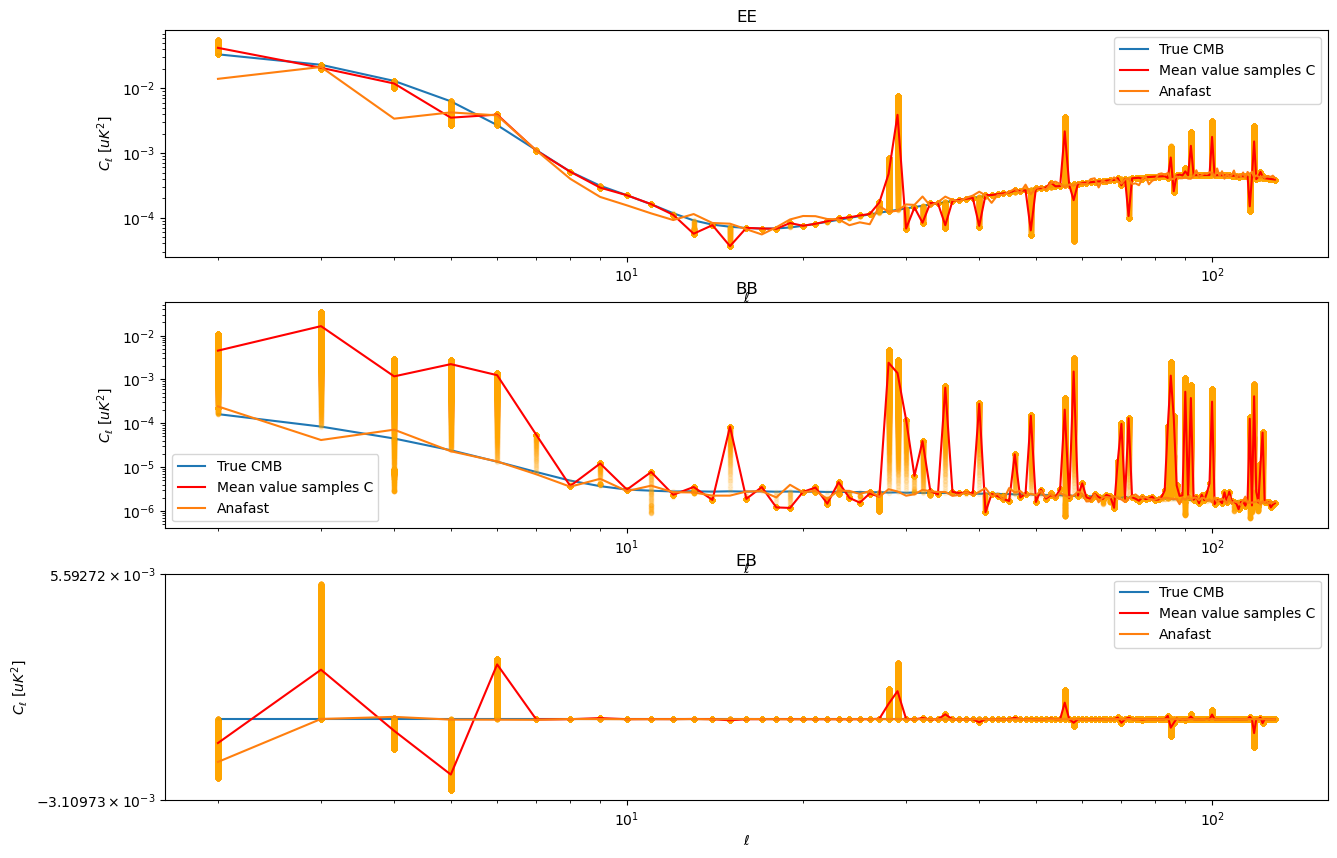

In [101]:
dict_color = {'fill': 'moccasin', 'border': 'orange'}
# c_ell_mean = np.mean(all_cell_samples, axis=0)
# c_ell_mean = np.mean(all_cell_samples[500:], axis=0)
# c_ell_mean = np.mean(all_cell_samples[-2:], axis=0)

# input_cmb_maps_extented = np.vstack([np.zeros_like(input_cmb_maps[0,0]),input_cmb_maps[0]])
input_cmb_maps_extented = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ell_input_cmb = hp.anafast(input_cmb_maps_extented, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

list_correl = ['EE', 'BB', 'EB']
burnin = 0
# burnin = -1000
c_ell_mean = np.mean(all_C_sample[burnin:], axis=0)
ell_arange = np.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1)
# factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
plt.figure(figsize=(15,10))
for j in range(number_correl_to_plot):
    plt.subplot(311+j)
    plt.title(list_correl[j])

    plt.plot(ell_arange, c_ell_true_CMB[j], label='True CMB')
    for ell in range(c_ell_mean.shape[1]):
        plt.plot(ell_arange[ell]*np.ones(number_steps_sampler+1), all_C_sample[:,j,ell], '.', color=dict_color['border'], alpha=0.1)
    # plt.plot(ell_arange, all_cell_samples[:,j,:].T, '.', color=dict_color['border'], label='Mean value samples C')

    plt.plot(ell_arange, c_ell_mean[j,:], color='red', label='Mean value samples C')
    plt.plot(ell_arange, c_ell_input_cmb[j,:], label='Anafast')
    if j < MICMAC_sampler_obj.nstokes:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.loglog()
    plt.legend()
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
plt.show()

In [88]:
log_space_r = np.logspace(-8,3, num=100)

if MICMAC_sampler_obj.r_true != 0:
        log_r_true = np.log10(MICMAC_sampler_obj.r_true)
        gap = .1
        log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
else:
        log_space_r = np.logspace(-20,-2, num=100)
c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

all_logproba_r = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_logspace, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [44]:
all_logproba_samples = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_sample, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_sample in all_r_sample])

In [45]:
r_fit = all_r_sample.mean()
print('R_fit :', r_fit)
r_max = log_space_r[np.where(all_logproba_r==all_logproba_r.max())[0][0]]
print('R_max :', r_max)

R_fit : 0.01016119706730332
R_max : 0.0101641416082135


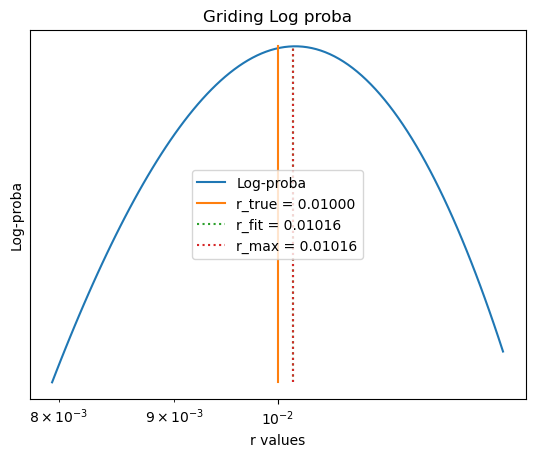

In [46]:
plt.plot(log_space_r, all_logproba_r, label='Log-proba')
plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r.min(), all_logproba_r.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
plt.plot([r_fit, r_fit], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_fit = {:.5f}'.format(r_fit))
plt.plot([r_max, r_max], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_max = {:.5f}'.format(r_max))
# plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('r values')
plt.ylabel('Log-proba')
plt.title('Griding Log proba')
# plt.ylim(ymax=all_logproba_r.max())
plt.legend()
plt.show()

In [47]:
all_r_sample.shape

(5001,)

In [48]:
red_c_ells_samples = np.zeros((number_steps_sampler, lmax+1-lmin, nstokes, nstokes))

for i in range(number_steps_sampler):
    red_c_ells_samples[i,...] = theoretical_red_cov_r0_total + all_r_sample[i]*theoretical_red_cov_r1_tensor


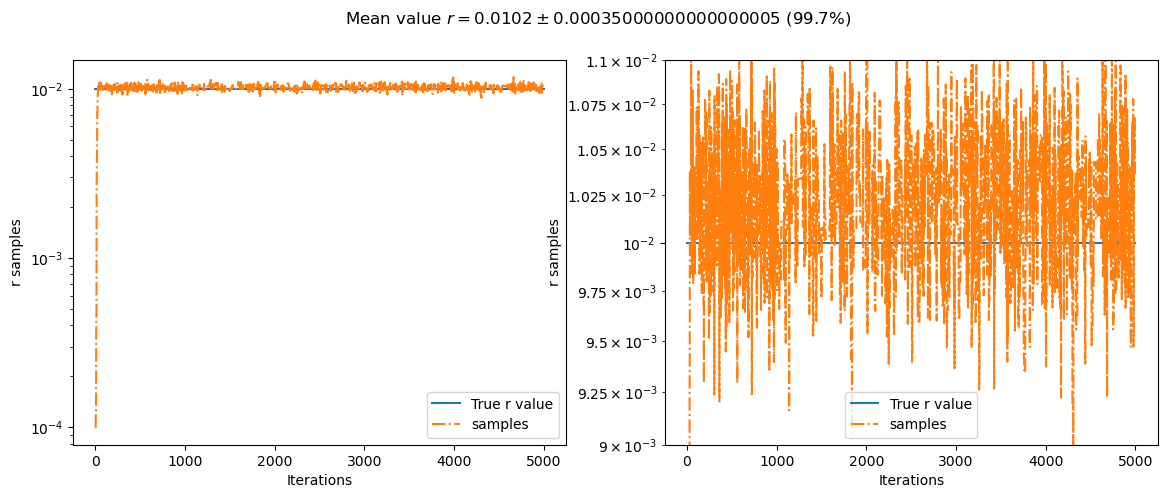

In [49]:
plt.figure(figsize=(14,5))

n_sigma = 3
transformed_samples = np.abs(all_r_sample - all_r_sample.mean())/(all_r_sample.std()) #< n_sigma
cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
mean_r = np.round(all_r_sample[cond].mean(), decimals=5)
std_r = np.round(all_r_sample[cond].std(), decimals=5)
plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%)")

plt.subplot(121)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.title('')
# plt.loglog()
plt.yscale('log')
plt.legend()

plt.subplot(122)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
# plt.loglog()
plt.yscale('log')
plt.legend()
plt.ylim(ymin=MICMAC_sampler_obj.r_true*.9, ymax=MICMAC_sampler_obj.r_true*1.1)
plt.show()

plt.show()

In [50]:
log_proba_r_true = MICMAC_sampler_obj.get_conditional_proba_C_from_r(MICMAC_sampler_obj.r_true, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)

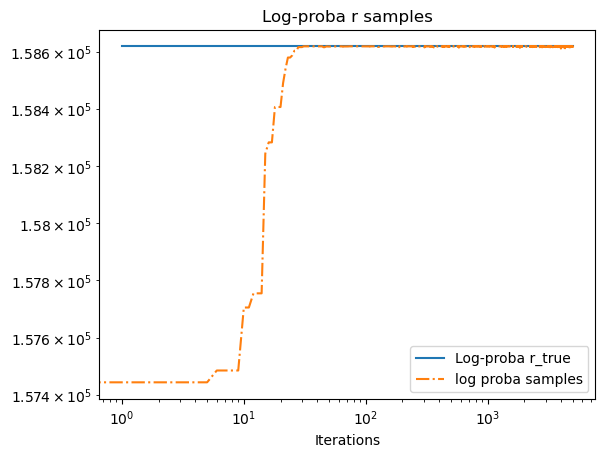

In [51]:
plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), all_logproba_samples[:], '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r samples')
plt.loglog()
plt.legend()
plt.show()

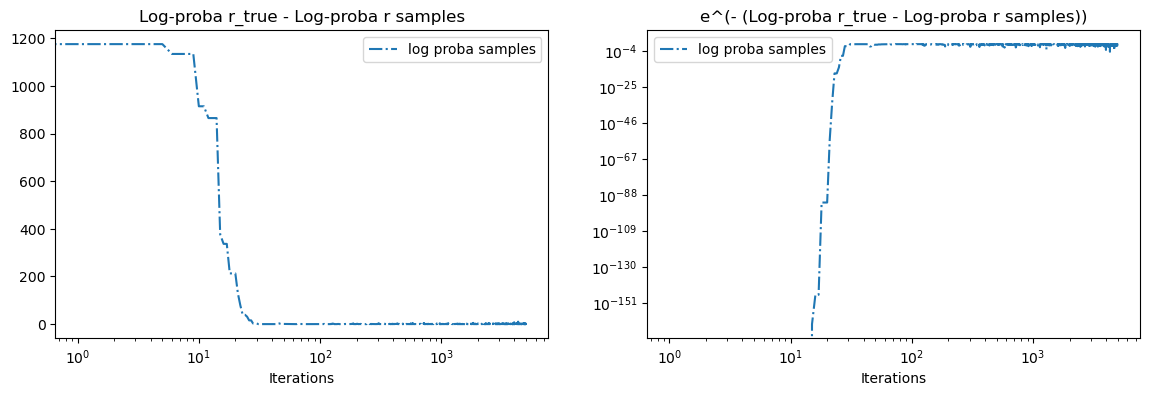

In [52]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), -(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r_true - Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.subplot(122)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), np.exp(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('e^(- (Log-proba r_true - Log-proba r samples))')
plt.loglog()
plt.legend()
plt.show()

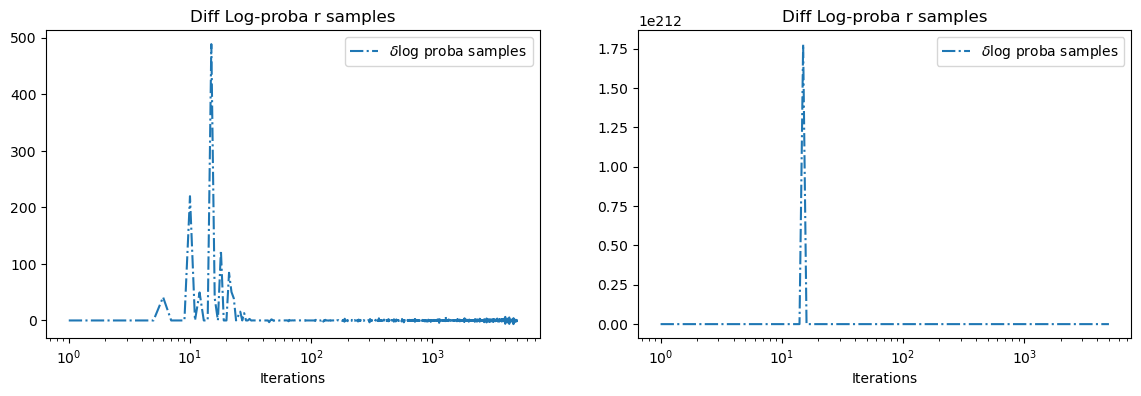

In [53]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler)+1, all_logproba_samples[1:]-all_logproba_samples[:-1], '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(number_steps_sampler)+1, np.exp(all_logproba_samples[1:]-all_logproba_samples[:-1]), '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.show()